In [9]:
import pathlib

import numpy as np
import scipy
import matplotlib.pyplot as plt
import polars as pl


In [10]:
def load_from_mat(
    file_path: str, start_time: float = 0, end_time: float = float("inf")
) -> pl.DataFrame:
    mat = scipy.io.loadmat(file_path)
    ts = mat["ans"]

    df = pl.DataFrame(
        {
            "time": ts[0, :],
            "travel": ts[1, :],
            "travel_rate": ts[2, :],
            "pitch": ts[3, :],
            "pitch_rate": ts[4, :],
            "elevation": ts[5, :],
            "elevation_rate": ts[6, :],
            "joystick_x": ts[7, :],
            "joystick_y": ts[8, :],
            "imu_pitch": ts[9, :],
            "imu_pitch_rate": ts[10, :],
            "imu_elevation": ts[11, :],
            "imu_elevation_rate": ts[12, :],
            "imu_travel": ts[13, :],
            "est_pitch": ts[14, :],
            "est_pitch_rate": ts[15, :],
            "est_elevation": ts[16, :],
            "est_elevation_rate": ts[17, :],
            "est_travel": ts[18, :],
        }
    )

    df = df.with_columns(
        pl.when((pl.col("time") >= 10) & (pl.col("time") <= 11))
        .then(1)
        .otherwise(0)
        .alias("disturbance"),
        pl.col("elevation_rate").rolling_mean(window_size=75).alias("elevation_roll"),
    )

    return df.filter((pl.col("time") >= start_time) & (pl.col("time") <= end_time))


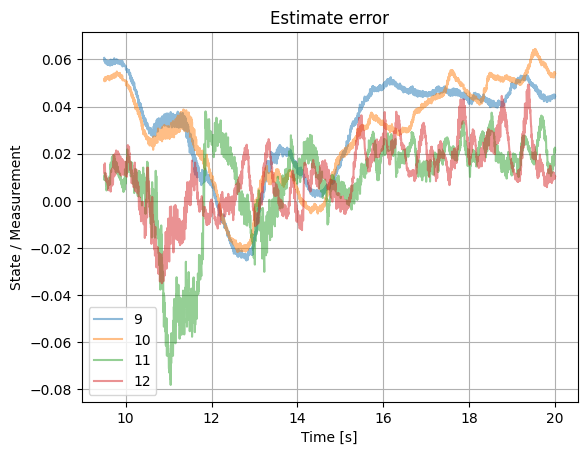

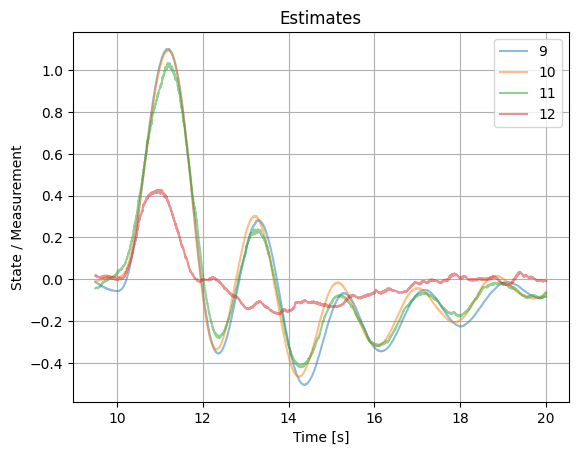

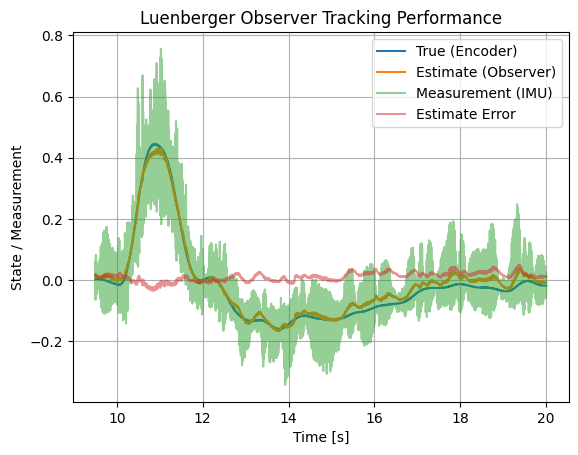

In [11]:
start_time = 9.5
end_time = 20

filename = "data/3_luenberger/{}.mat"

data_9 = load_from_mat(filename.format(9), start_time, end_time)
data_10 = load_from_mat(filename.format(10), start_time, end_time)
data_11 = load_from_mat(filename.format(11), start_time, end_time)
data_12 = load_from_mat(filename.format(12), start_time, end_time)


plt.figure()
plt.plot(data_9["time"], data_9["est_pitch"] - data_9["pitch"], label="9", alpha=0.5)
plt.plot(
    data_10["time"], data_10["est_pitch"] - data_10["pitch"], label="10", alpha=0.5
)
plt.plot(
    data_11["time"], data_11["est_pitch"] - data_11["pitch"], label="11", alpha=0.5
)
plt.plot(
    data_12["time"], data_12["est_pitch"] - data_12["pitch"], label="12", alpha=0.5
)
plt.xlabel("Time [s]")
plt.ylabel("State / Measurement")
plt.grid(True)
plt.legend()
plt.title("Estimate error")
plt.show()


plt.figure()
plt.plot(data_9["time"], data_9["est_pitch"], label="9", alpha=0.5)
plt.plot(data_10["time"], data_10["est_pitch"], label="10", alpha=0.5)
plt.plot(data_11["time"], data_11["est_pitch"], label="11", alpha=0.5)
plt.plot(data_12["time"], data_12["est_pitch"], label="12", alpha=0.5)
plt.xlabel("Time [s]")
plt.ylabel("State / Measurement")
plt.grid(True)
plt.legend()
plt.title("Estimates")
plt.show()


plt.figure()
data = data_12
plt.plot(data["time"], data["pitch"], label="True (Encoder)")
plt.plot(data["time"], data["est_pitch"], label="Estimate (Observer)")
plt.plot(data["time"], data["imu_pitch"], label="Measurement (IMU)", alpha=0.5)
plt.plot(
    data["time"],
    data["est_pitch"] - data["pitch"],
    label="Estimate Error",
    alpha=0.5,
)
plt.xlabel("Time [s]")
plt.ylabel("State / Measurement")
plt.grid(True)
plt.legend()
plt.title("Luenberger Observer Tracking Performance")
plt.show()

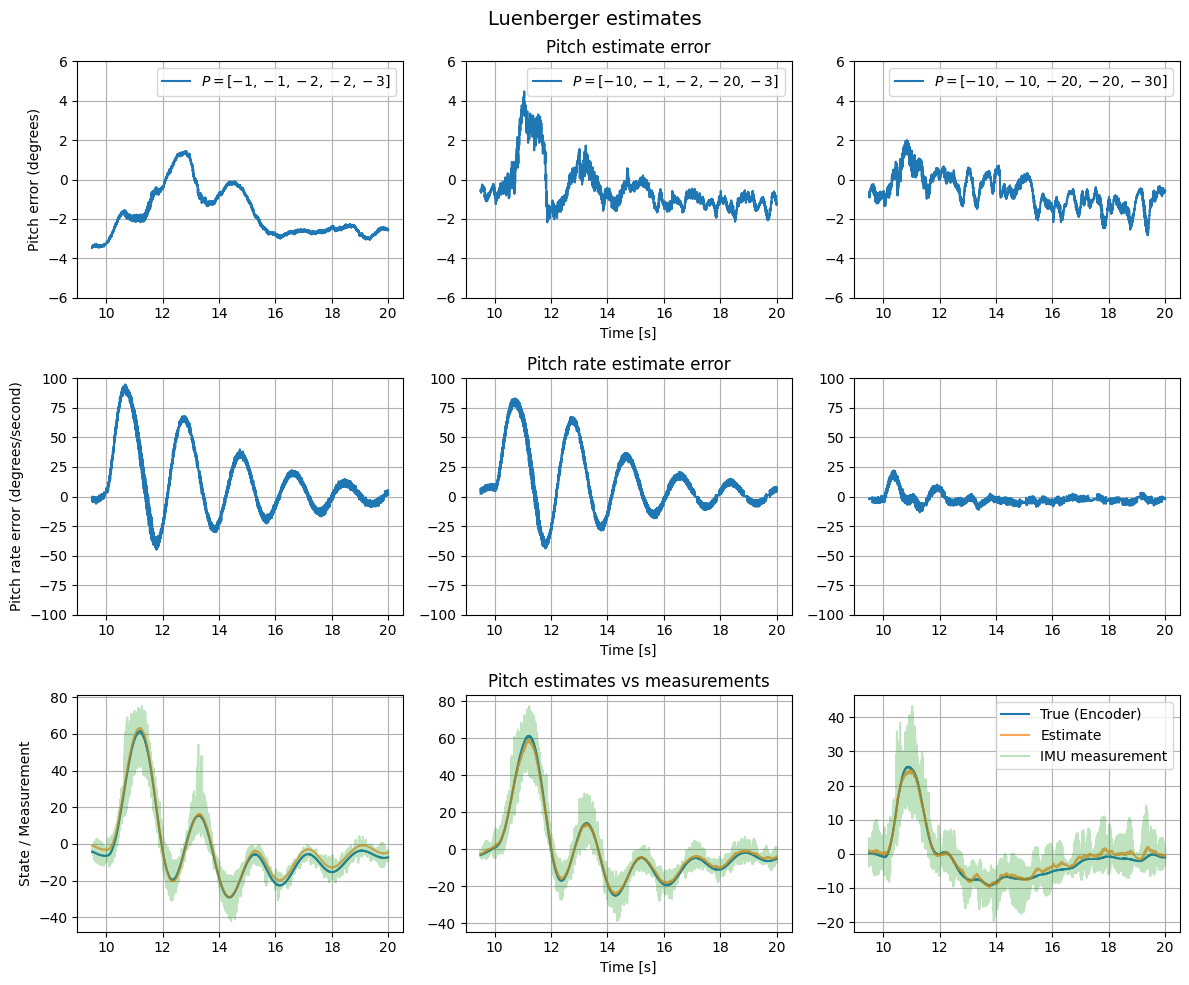

In [33]:
rtd = 180 / np.pi

fig, ((ax1, ax2, ax3), (bx1, bx2, bx3), (cx1, cx2, cx3)) = plt.subplots(
    3, 3, figsize=(12, 10)
)

ax1.plot(
    data_9["time"],
    (data_9["pitch"] - data_9["est_pitch"]) * rtd,
    label=r"$P = [-1, -1, -2, -2, -3]$",
)
ax1.set_ylabel("Pitch error (degrees)")
ax1.set_ylim([-6, 6])
ax1.legend()
ax1.grid(True)

ax2.plot(
    data_11["time"],
    (data_11["pitch"] - data_11["est_pitch"]) * rtd,
    label=r"$P = [-10, -1, -2, -20, -3]$",
)
ax2.set_xlabel("Time [s]")
ax2.set_title("Pitch estimate error")
ax2.set_ylim([-6, 6])
ax2.legend()
ax2.grid(True)

ax3.plot(
    data_12["time"],
    (data_12["pitch"] - data_12["est_pitch"]) * rtd,
    label=r"$P = [-10, -10, -20, -20, -30]$",
)
ax3.set_ylim([-6, 6])
ax3.legend()
ax3.grid(True)

bx1.plot(
    data_9["time"],
    (data_9["pitch_rate"] - data_9["est_pitch_rate"]) * rtd,
    label=r"$Q = 10^{-2}$",
)
bx1.set_ylabel("Pitch rate error (degrees/second)")
bx1.set_ylim([-100, 100])
bx1.grid(True)

bx2.plot(
    data_11["time"],
    (data_11["pitch_rate"] - data_11["est_pitch_rate"]) * rtd,
    label=r"$Q = 10^{-4}$",
)
bx2.set_xlabel("Time [s]")
bx2.set_title("Pitch rate estimate error")
bx2.set_ylim([-100, 100])
bx2.grid(True)

bx3.plot(
    data_12["time"],
    (data_12["pitch_rate"] - data_12["est_pitch_rate"]) * rtd,
    label=r"$Q = 10^{-6}$",
)
bx3.set_ylim([-100, 100])
bx3.grid(True)


cx1.plot(data_9["time"], data_9["pitch"] * rtd, label="True (Encoder)")
cx1.plot(data_9["time"], data_9["est_pitch"] * rtd, label="Estimate", alpha=0.7)
cx1.plot(data_9["time"], data_9["imu_pitch"] * rtd, label="IMU measurement", alpha=0.3)
cx1.set_ylabel("State / Measurement")
cx1.grid(True)

cx2.plot(data_11["time"], data_11["pitch"] * rtd, label="True (Encoder)")
cx2.plot(data_11["time"], data_11["est_pitch"] * rtd, label="Estimate", alpha=0.7)
cx2.plot(
    data_11["time"], data_11["imu_pitch"] * rtd, label="IMU measurement", alpha=0.3
)
cx2.set_xlabel("Time [s]")
cx2.grid(True)
cx2.set_title("Pitch estimates vs measurements")

cx3.plot(data_12["time"], data_12["pitch"] * rtd, label="True (Encoder)")
cx3.plot(data_12["time"], data_12["est_pitch"] * rtd, label="Estimate", alpha=0.7)
cx3.plot(
    data_12["time"], data_12["imu_pitch"] * rtd, label="IMU measurement", alpha=0.3
)
cx3.grid(True)
cx3.legend()

plt.suptitle("Luenberger estimates", fontsize=14)
plt.tight_layout()
plt.show()